#### Voronoi Binning

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from pycasso2.resampling import ReSamplingMatrixNonUniform

In [4]:
with open("sci_files_object_mapping.json", "r") as f:
    sci_files_object_mapping = json.load(f)

In [19]:
class VorbinUtils:
    def __init__(self, filename, ini_w, fin_w):
        with fits.open(filename) as hdul:
            self.data = hdul["SCI"].data
            self.var = hdul["VAR"].data
            self.dq = hdul["DQ"].data

        fits_header = fits.getheader(filename, ext=("sci", 1))
        wcs = WCS(fits_header, naxis=[3])
        wavelength = wcs.wcs_pix2world(np.arange(fits_header["NAXIS3"]), 0)[0]

        self.ini_index = np.where(np.round(wavelength) == ini_w)[0][0]
        self.fin_index = np.where(np.round(wavelength) == fin_w)[0][0]

    def voronoi_bin(self, target_sn):
        sample = self.data[self.ini_index : self.fin_index, :, :]
        sample_var = self.var[self.ini_index : self.fin_index, :, :]
        sample_noise = np.sqrt(sample_var)

        signal = np.nanmean(sample, axis=0)
        noise = np.nanmean(sample_noise, axis=0) + 1e-10
        x, y = np.indices(signal.shape)
        x = x.ravel()
        y = y.ravel()
        bin_num, x_bin, y_bin, x_bar, y_bar, sn, n_pixels, scale = voronoi_2d_binning(
            x, y, signal.ravel(), noise.ravel(), target_sn, plot=0, quiet=1
        )

        self.x_bar = x_bar
        self.y_bar = y_bar

        threshold = 0.3
        self.bin_ids = list(set(bin_num))
        binned_data = {}
        for bin_id in self.bin_ids:
            binned_data[bin_id] = {}
            bin_mask = bin_num == bin_id
            binx = x[bin_mask]
            biny = y[bin_mask]
            bin_mask = np.zeros(self.data[0, :, :].shape, dtype=bool)

            signal_sum = np.zeros(self.data[:, 0, 0].shape)
            var_sum = np.zeros(self.var[:, 0, 0].shape)

            for pixx, pixy in zip(binx, biny):
                signal_sum += self.data[:, pixx, pixy]
                var_sum += self.var[:, pixx, pixy]
                bin_mask[pixx, pixy] = True

            binned_data[bin_id]["quality_map"] = np.zeros(self.data.shape[0])
            for wavl in np.arange(self.data.shape[0]):
                wavl_dq_plane = self.dq[wavl, :, :]
                bad_data_ratio = np.round(
                    np.sum(wavl_dq_plane[bin_mask]) / np.sum(bin_num == bin_id), 2
                )
                binned_data[bin_id]["quality_map"][wavl] = np.where(
                    bad_data_ratio >= threshold, 2, 0
                ).astype(int)
            bin_signal = signal_sum / len(binx)
            bin_var = var_sum / len(binx)
            binned_data[bin_id]["signal"] = bin_signal
            binned_data[bin_id]["var"] = bin_var

        self.binned_data = binned_data

    def calculate_true_snr(self, plot=False):
        true_snr = {}
        for bin_id in self.bin_ids:
            signal = np.mean(
                self.binned_data[bin_id]["signal"][self.ini_index : self.fin_index]
            )
            noise = np.mean(
                np.sqrt(
                    self.binned_data[bin_id]["var"][self.ini_index : self.fin_index]
                )
            )
            true_snr[bin_id] = signal / noise

        all_bins = list(true_snr.keys())
        x_all = np.array(self.x_bar)[all_bins]
        y_all = np.array(self.y_bar)[all_bins]
        snr_values = np.array(list(true_snr.values()))
        good_snr_indices = [index for index, snr in enumerate(snr_values) if snr > 5]
        print(f"Good bins: {len(good_snr_indices)}")
        print(f"Share of good bins: {np.round(len(good_snr_indices)/len(all_bins), 3)}")
        bad_snr_indices = [index for index, snr in enumerate(snr_values) if snr < 5]
        really_bad_snr_indices = [
            index for index, snr in enumerate(snr_values) if snr < 4
        ]

        if plot:
            # plt.figure(figsize=(15, 10))
            plt.scatter(
                x_all[bad_snr_indices],
                y_all[bad_snr_indices],
                c="black",
                marker="x",
                s=90,
                label="SNR < 5",
            )
            plt.scatter(
                x_all[really_bad_snr_indices],
                y_all[really_bad_snr_indices],
                c="red",
                marker="x",
                s=90,
                label="SNR < 4",
            )

            cmap = plt.cm.jet
            sc = plt.scatter(
                x_all,
                y_all,
                c=snr_values,
                cmap=cmap,
                vmin=min(snr_values),
                vmax=max(snr_values),
            )
            plt.colorbar(sc, ax=plt.gca(), label="SNR")
            plt.legend()
            plt.tight_layout()
            plt.gca().set_aspect("equal")
            plt.title("SNR heatmap - GSN 069")
            plt.xlabel("X coordinate")
            plt.ylabel("Y coordinate")
            plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Good bins: 27
Share of good bins: 0.587


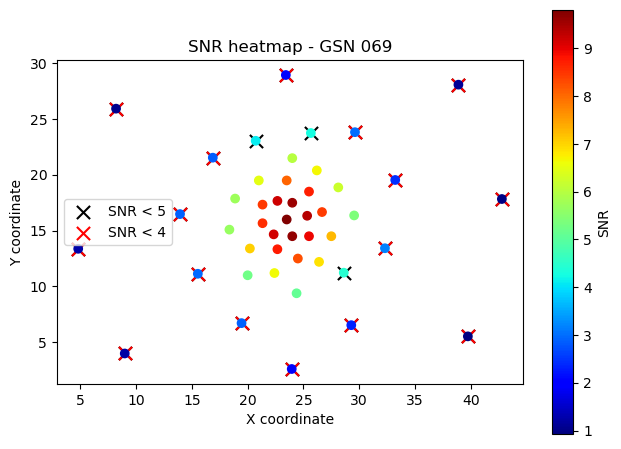

In [20]:
# GSN 069
ini_w = 5655
fin_w = 5745
target_sn = 15

object_name = list(sci_files_object_mapping.keys())[1]
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_pca_combined_spectra_ext_3D.fits"
vor = VorbinUtils(filename, ini_w, fin_w)
vor.voronoi_bin(target_sn)
vor.calculate_true_snr(plot=True)

In [21]:
# eRO-QPE2

ini_w = 5655
fin_w = 5745
target_sn = 15

object_name = list(sci_files_object_mapping.keys())[0]
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_pca_combined_spectra_ext_3D.fits"
vor = VorbinUtils(filename, ini_w, fin_w)
vor.voronoi_bin(target_sn)
vor.calculate_true_snr(plot=True)

FileNotFoundError: [Errno 2] No such file or directory: 'redux/ero-qpe2_pca_combined_spectra_ext_3D.fits'

#### Resampling

In [8]:
def resampling(res_lambda_min, res_lambda_max, rfwave, rfflux, rferr, qual):
    lresamp = np.arange(res_lambda_min, res_lambda_max, 1)
    matrix = ReSamplingMatrixNonUniform(rfwave, lresamp)
    fresamp = np.dot(matrix, rfflux)
    errresamp = np.dot(matrix, rferr)
    qualresamp = np.dot(matrix, qual)

    for i in range(len(qualresamp)):
        if lresamp[i] < min(rfwave):
            qualresamp[i] = 2

        elif lresamp[i] > max(rfwave):
            qualresamp[i] = 2

        if qualresamp[i] > 0:
            qualresamp[i] = 2

    return lresamp, fresamp, errresamp, qualresamp

In [9]:
lambda_min = int(np.min(wavelength))
lambda_max = int(np.max(wavelength))
res_wavelenght, res_signal, res_var, res_quality_map = resampling(
    res_lambda_min=lambda_min,
    res_lambda_max=lambda_max,
    rfwave=wavelength,
    rfflux=binned_data[0]["signal"],
    rferr=binned_data[0]["var"],
    qual=binned_data[0]["quality_map"],
)

resampled_data = {}
for bin_id, bin_data in enumerate(binned_data.values()):
    res_wavelenght, res_signal, res_var, res_quality_map = resampling(
        res_lambda_min=lambda_min,
        res_lambda_max=lambda_max,
        rfwave=wavelength,
        rfflux=binned_data[bin_id]["signal"],
        rferr=binned_data[bin_id]["var"],
        qual=binned_data[bin_id]["quality_map"],
    )
    resampled_data[bin_id] = {}
    resampled_data[bin_id]["wavelength"] = res_wavelenght
    resampled_data[bin_id]["signal"] = res_signal
    resampled_data[bin_id]["var"] = res_var
    resampled_data[bin_id]["quality_map"] = res_quality_map

#### Create input files

In [10]:
# Create obs input files
for bin_id, bin_data in enumerate(resampled_data.values()):
    input_data = np.stack(
        [
            bin_data["wavelength"],
            bin_data["signal"],
            np.sqrt(bin_data["var"]),
            bin_data["quality_map"],
        ],
        axis=1,
    )
    np.savetxt(
        f"redux/starlight_synthesis/gsn069/obs_dir/{bin_id}",
        input_data,
        fmt=["%f", "%f", "%f", "%d"],
    )

/tmp/ipykernel_12670/3582690033.py:7: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(bin_data["var"]),


In [13]:
# Create mask input files
maskfilename = "MaskEmissionAbsortionGSN069"

with open("redux/gsn069_masks.json", "r") as f:
    masks_json = json.load(f)

window_range = 8
masks_json["emission_centers"] = np.round(masks_json["emission_centers"])
masks_json["emission_windows"] = [
    [emiss_center - window_range, emiss_center + window_range]
    for emiss_center in masks_json["emission_centers"]
]


all_masks = masks_json["emission_windows"]
all_masks.extend(masks_json["absortion_windows"])
nmasks = len(all_masks)

with open(f"redux/starlight_synthesis/{maskfilename}", "w") as file:
    file.write(str(nmasks) + "\n")
    for window in all_masks:
        file.write(f"{window[0]} {window[1]} 0 \n")